In [1]:
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator as kmf
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import matplotlib.patches as mpatches

In [2]:
cell_type = 'B cells Naive'
path = "../data/brca/tcga/processed/Wu/ct_minor/weights_CID3586.csv"
cell_estimation = pd.read_csv(path,sep=',')
cell_estimation.head()

,B cells Memory,B cells Naive,T cells CD8+,T cells CD4+,NK cells,NKT cells,Monocyte
E2-A1IU,0.004598,0.0,0.0,0.0,0.078833,0.771310,0.145260
AO-A03U,0.004850,0.0,0.0,0.0,0.000000,0.590898,0.404252
E9-A1NH,0.004966,0.0,0.0,0.0,0.000000,0.782599,0.212435
BH-A1EY,0.004965,0.0,0.0,0.0,0.000000,0.633172,0.361863
AO-A1KS,0.004551,0.0,0.0,0.0,0.224304,0.654061,0.117084


In [3]:
cell_estimation.dtypes

B cells Memory    float64
B cells Naive     float64
T cells CD8+      float64
T cells CD4+      float64
NK cells          float64
NKT cells         float64
Monocyte          float64
dtype: object

In [4]:
path = "../data/brca/tcga/processed/Wu/ct_minor/clinical_CID3586.csv"
survival = pd.read_csv(path,sep=',')
survival = survival.set_index(survival.patientId)
survival.head()

,patientId,OS_MONTHS,OS_STATUS,DFS_MONTHS,DFS_STATUS
patientId,,,,,
3C-AAAU,3C-AAAU,133.050597,0:LIVING,59.440444,1:Recurred/Progressed
3C-AALI,3C-AALI,131.669790,0:LIVING,131.669790,0:DiseaseFree
3C-AALJ,3C-AALJ,48.459743,0:LIVING,48.459743,0:DiseaseFree
3C-AALK,3C-AALK,47.604958,0:LIVING,NaN,NaN
4H-AAAK,4H-AAAK,11.440971,0:LIVING,11.440971,0:DiseaseFree


In [5]:
survival.dtypes

patientId      object
OS_MONTHS     float64
OS_STATUS      object
DFS_MONTHS    float64
DFS_STATUS     object
dtype: object

In [6]:
survival_test = cell_estimation.merge(survival,left_index=True,right_index=True,how='inner')
survival_test.head()

,B cells Memory,B cells Naive,T cells CD8+,T cells CD4+,NK cells,NKT cells,Monocyte,patientId,OS_MONTHS,OS_STATUS,DFS_MONTHS,DFS_STATUS
E2-A1IU,0.004598,0.0,0.0,0.0,0.078833,0.771310,0.145260,E2-A1IU,11.079331,0:LIVING,11.079331,0:DiseaseFree
AO-A03U,0.004850,0.0,0.0,0.0,0.000000,0.590898,0.404252,AO-A03U,58.947299,1:DECEASED,58.947299,0:DiseaseFree
E9-A1NH,0.004966,0.0,0.0,0.0,0.000000,0.782599,0.212435,E9-A1NH,18.936779,0:LIVING,18.936779,0:DiseaseFree
BH-A1EY,0.004965,0.0,0.0,0.0,0.000000,0.633172,0.361863,BH-A1EY,17.687477,1:DECEASED,NaN,NaN
AO-A1KS,0.004551,0.0,0.0,0.0,0.224304,0.654061,0.117084,AO-A1KS,11.506723,0:LIVING,11.506723,0:DiseaseFree


In [7]:
survival_test = survival_test.rename({"DFS_MONTHS": "DFS", 
                                      "OS_MONTHS":"OS",
                                      "OS_STATUS":"OS_E",
                                      "DFS_STATUS":"DFS_E",
                                     }, axis=1)
survival_test['OS_E'] = pd.to_numeric(survival_test['OS_E'].str.split(':').str[0])
survival_test['DFS_E'] = pd.to_numeric(survival_test['DFS_E'].str.split(':').str[0])
survival_test = survival_test.drop(["patientId"], axis=1)
survival_test.head()

,B cells Memory,B cells Naive,T cells CD8+,T cells CD4+,NK cells,NKT cells,Monocyte,OS,OS_E,DFS,DFS_E
E2-A1IU,0.004598,0.0,0.0,0.0,0.078833,0.771310,0.145260,11.079331,0,11.079331,0.0
AO-A03U,0.004850,0.0,0.0,0.0,0.000000,0.590898,0.404252,58.947299,1,58.947299,0.0
E9-A1NH,0.004966,0.0,0.0,0.0,0.000000,0.782599,0.212435,18.936779,0,18.936779,0.0
BH-A1EY,0.004965,0.0,0.0,0.0,0.000000,0.633172,0.361863,17.687477,1,NaN,NaN
AO-A1KS,0.004551,0.0,0.0,0.0,0.224304,0.654061,0.117084,11.506723,0,11.506723,0.0


In [8]:
survival_test.dtypes

B cells Memory    float64
B cells Naive     float64
T cells CD8+      float64
T cells CD4+      float64
NK cells          float64
NKT cells         float64
Monocyte          float64
OS                float64
OS_E                int64
DFS               float64
DFS_E             float64
dtype: object

In [9]:
survival_test = survival_test.dropna()

In [10]:
survival_test.shape

(927, 11)

In [11]:
def generate_levels(df, interest, test_type):
    survival_reorder = df.sort_values(interest,axis=0,ascending=False).copy()
    survival_E = {1:True, 0:False}
    E = list(survival_reorder['%s_E'%test_type])
    E = [survival_E[value] for value in E]
    mid_point = int(len(E)/2)
    E_high = E[:mid_point]
    E_low = E[mid_point:]

    S = list(survival_reorder['%s'%test_type])
    S_high = S[:mid_point]
    S_low = S[mid_point:]    
    dfA = pd.DataFrame({'E': E_high, 'T': S_high, 'groupA': 1})
    dfB = pd.DataFrame({'E': E_low, 'T': S_low, 'groupA': 0})
    df = pd.concat([dfA, dfB])
    cph = CoxPHFitter().fit(df, 'T', 'E')
    return S_high,S_low,E_high,E_low, cph                                 

In [12]:
def retrieve_stats(cph):
    p = cph.summary["p"].iloc[0]
    hr = cph.hazard_ratios_.iloc[0]
    ci_low = hr + cph.confidence_intervals_.iloc[0,0]
    ci_high = hr + cph.confidence_intervals_.iloc[0,1]
    return p, hr, ci_low, ci_high

In [13]:
survival.describe()

,OS_MONTHS,DFS_MONTHS
count,1080.000000,937.000000
mean,40.812494,37.911767
std,39.308977,36.116740
min,0.000000,0.000000
25%,14.720387,14.268337
50%,27.073676,24.986028
75%,55.002137,50.958346
max,282.901009,281.290068


In [14]:
survival_test.columns

Index(['B cells Memory', 'B cells Naive', 'T cells CD8+', 'T cells CD4+',
       'NK cells', 'NKT cells', 'Monocyte', 'OS', 'OS_E', 'DFS', 'DFS_E'],
      dtype='object')

In [15]:
study = "GSE176078"

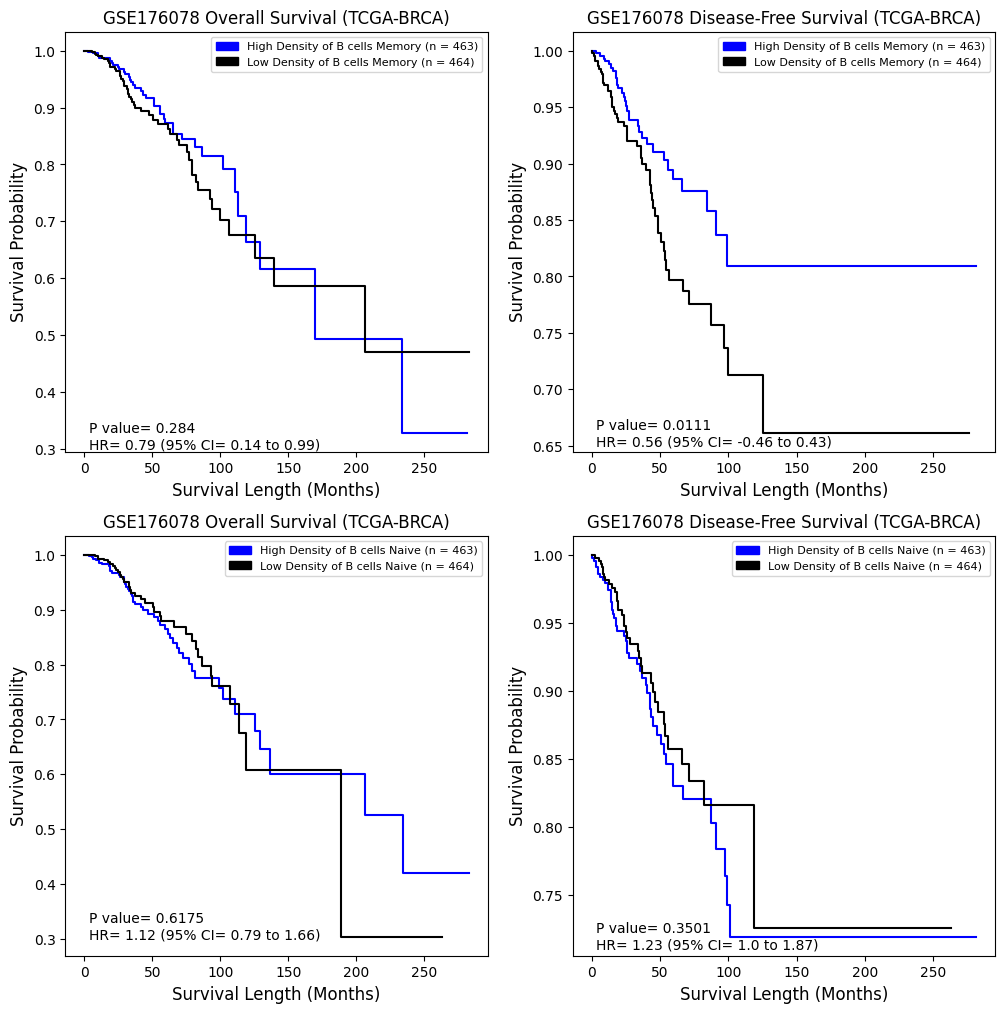

In [16]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# subplot 1
cell_type = 'B cells Memory'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")
axs[0, 0].step(*kmf(E_high, S_high), c='b')
axs[0, 0].step(*kmf(E_low, S_low), c='k')
#axs[0, 0].set_xticks(np.arange(0, 73, 24))
#axs[0, 0].set_yticks(np.arange(0.2, 1.1, 0.2))
axs[0, 0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0, 0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0, 0].text(3,0.3, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0, 0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[0, 0].set_title(f'{study} Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 2
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[0, 1].step(*kmf(E_high, S_high), c='b')
axs[0, 1].step(*kmf(E_low, S_low), c='k')
axs[0, 1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0, 1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0, 1].text(3,0.65, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0, 1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[0, 1].set_title(f'{study} Disease-Free Survival (TCGA-BRCA)', fontsize=12)

# subplot 3
cell_type = 'B cells Naive'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")
axs[1, 0].step(*kmf(E_high, S_high), c='b')
axs[1, 0].step(*kmf(E_low, S_low), c='k')
axs[1, 0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1, 0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1, 0].text(3,0.3, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1, 0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[1, 0].set_title(f'{study} Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 4
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[1, 1].step(*kmf(E_high, S_high), c='b')
axs[1, 1].step(*kmf(E_low, S_low), c='k')
axs[1, 1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1, 1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1, 1].text(3,0.71, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1, 1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[1, 1].set_title(f'{study} Disease-Free Survival (TCGA-BRCA)', fontsize=12)
path = f"../figures/{study}/With_No_Other/B_cell_survival_logranktest.png"
plt.savefig(path,format='png')
plt.show()
plt.close()


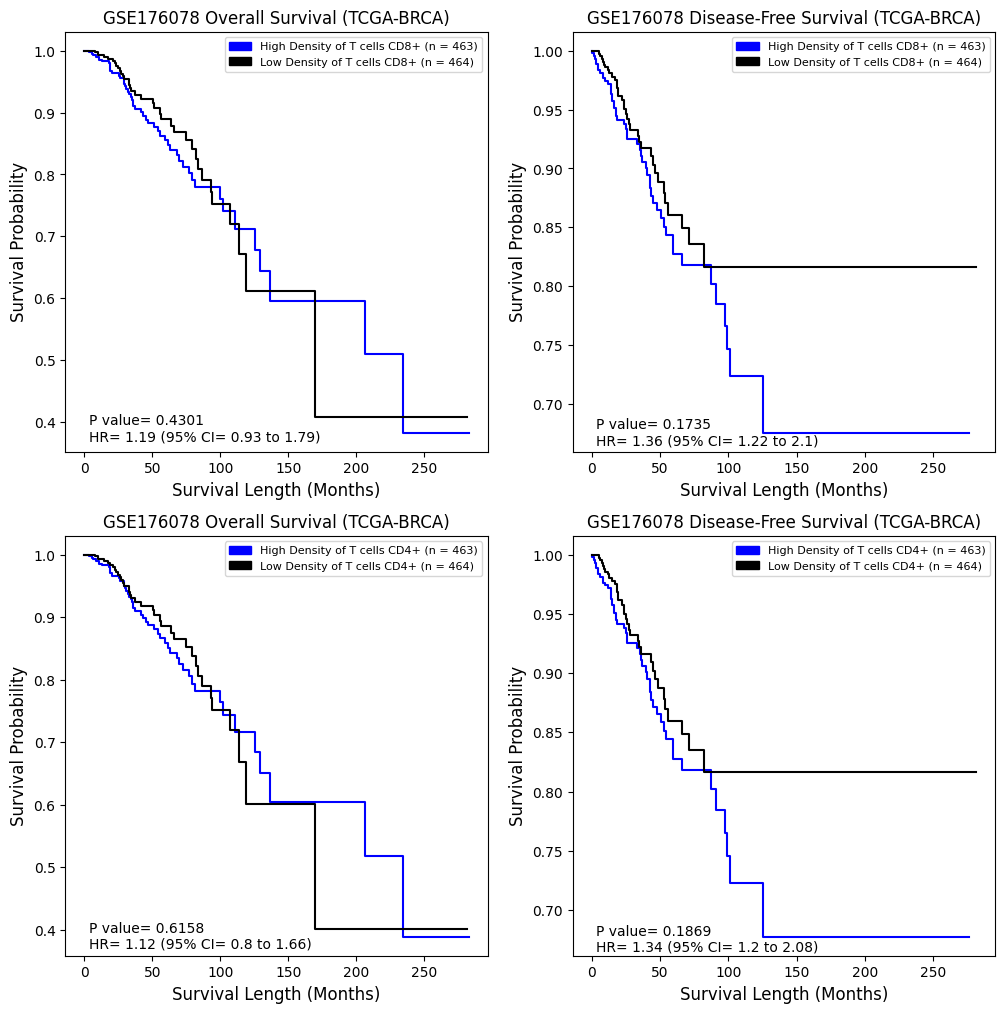

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# subplot 1
cell_type = 'T cells CD8+'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")
axs[0, 0].step(*kmf(E_high, S_high), c='b')
axs[0, 0].step(*kmf(E_low, S_low), c='k')
#axs[0, 0].set_xticks(np.arange(0, 73, 24))
#axs[0, 0].set_yticks(np.arange(0.2, 1.1, 0.2))
axs[0, 0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0, 0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0, 0].text(3,0.37, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0, 0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[0, 0].set_title(f'{study} Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 2
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[0, 1].step(*kmf(E_high, S_high), c='b')
axs[0, 1].step(*kmf(E_low, S_low), c='k')
axs[0, 1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0, 1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0, 1].text(3,0.665, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0, 1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[0, 1].set_title(f'{study} Disease-Free Survival (TCGA-BRCA)', fontsize=12)

# subplot 3
cell_type = 'T cells CD4+'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")
axs[1, 0].step(*kmf(E_high, S_high), c='b')
axs[1, 0].step(*kmf(E_low, S_low), c='k')
axs[1, 0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1, 0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1, 0].text(3,0.37, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1, 0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[1, 0].set_title(f'{study} Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 4
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[1, 1].step(*kmf(E_high, S_high), c='b')
axs[1, 1].step(*kmf(E_low, S_low), c='k')
axs[1, 1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1, 1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1, 1].text(3,0.665, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1, 1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[1, 1].set_title(f'{study} Disease-Free Survival (TCGA-BRCA)', fontsize=12)
path = f"../figures/{study}/With_No_Other/T_cell_survival_logranktest.png"
plt.savefig(path,format='png')
plt.show()
plt.close()


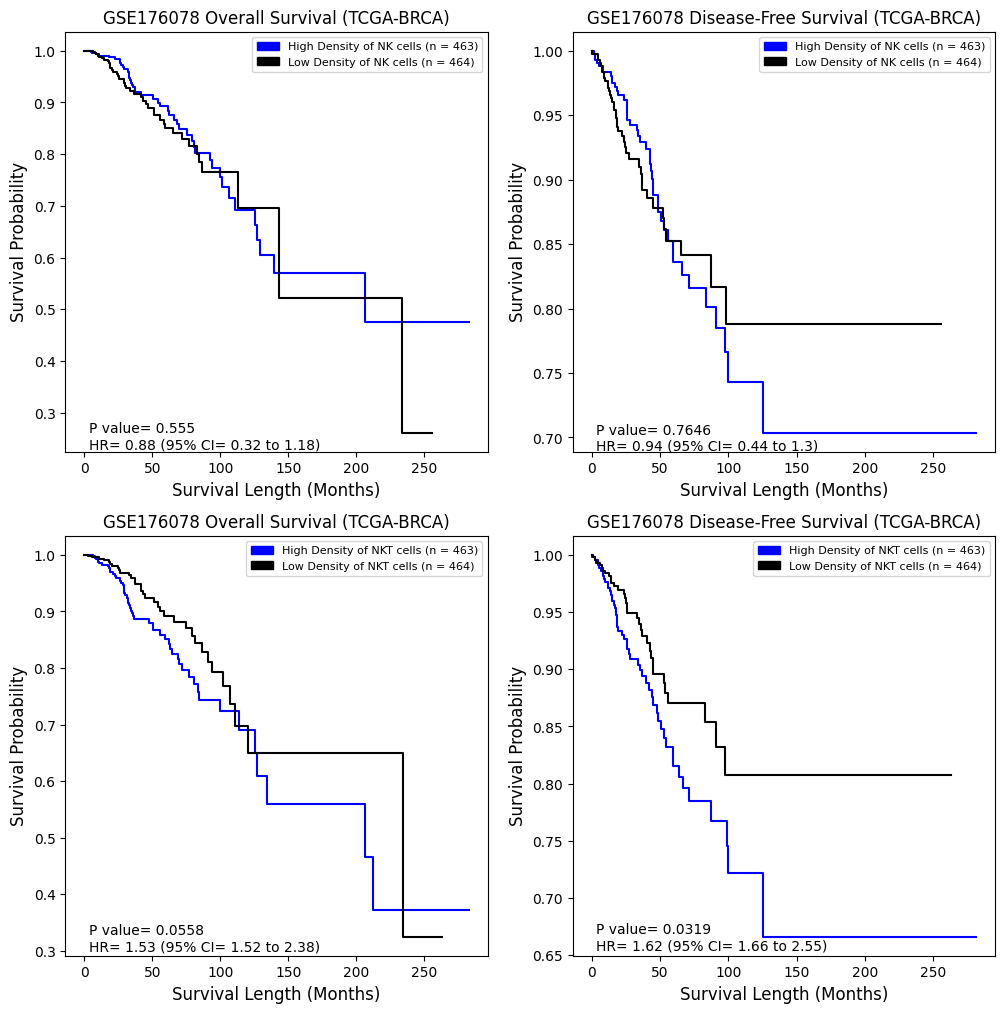

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# subplot 1
cell_type = 'NK cells'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")
axs[0, 0].step(*kmf(E_high, S_high), c='b')
axs[0, 0].step(*kmf(E_low, S_low), c='k')
#axs[0, 0].set_xticks(np.arange(0, 73, 24))
#axs[0, 0].set_yticks(np.arange(0.2, 1.1, 0.2))
axs[0, 0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0, 0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0, 0].text(3,0.23, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0, 0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[0, 0].set_title(f'{study} Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 2
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[0, 1].step(*kmf(E_high, S_high), c='b')
axs[0, 1].step(*kmf(E_low, S_low), c='k')
axs[0, 1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0, 1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0, 1].text(3,0.69, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0, 1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[0, 1].set_title(f'{study} Disease-Free Survival (TCGA-BRCA)', fontsize=12)

# subplot 3
cell_type = 'NKT cells'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")
axs[1, 0].step(*kmf(E_high, S_high), c='b')
axs[1, 0].step(*kmf(E_low, S_low), c='k')
axs[1, 0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1, 0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1, 0].text(3,0.3, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1, 0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[1, 0].set_title(f'{study} Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 4
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[1, 1].step(*kmf(E_high, S_high), c='b')
axs[1, 1].step(*kmf(E_low, S_low), c='k')
axs[1, 1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1, 1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1, 1].text(3,0.655, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1, 1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[1, 1].set_title(f'{study} Disease-Free Survival (TCGA-BRCA)', fontsize=12)
path = f"../figures/{study}/With_No_Other/NK_cell_survival_logranktest.png"
plt.savefig(path,format='png')
plt.show()
plt.close()
